In [1]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using TypedTables
using Measurements
using TypedTables
using HypothesisTests

In [2]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
using Revise 

In [4]:
using BAT

┌ Info: Precompiling BAT [c0cd4b16-88b7-57fa-983b-ab80aecada7e]
└ @ Base loading.jl:1317


In [5]:
using TypedTables

# 1-D Toy: 

In [6]:
m1 = MvNormal([10,10], [0.1,0.1])
m2 = MvNormal([-10,-10], [0.1,0.1])
m3 = MvNormal([10,-10], [0.1,0.1])
m4 = MvNormal([-10,10], [0.1,0.1])
m5 = MvNormal([0,1], [0.1,0.1])

mixture_model = MixtureModel(MvNormal[m1, m2, m3, m4, m5]);

In [7]:
prior = NamedTupleDist(a = [Uniform(-150,150), Uniform(-150,150)])
# prior = NamedTupleDist(a = [truncated(Normal(0, 200), -150, 150), truncated(Normal(0, 200), -150, 150)])

likelihood = let model = mixture_model
    params -> LogDVal(logpdf(model, params.a))
end

posterior = PosteriorDensity(likelihood, prior);

log_volume = BAT.log_volume(BAT.spatialvolume(posterior.parbounds))

11.407564949312402

In [8]:
n_samples = 5*10^5 

500000

In [9]:
mcmc = MCMCSampling(mcalg = MetropolisHastings(), nchains=5, nsteps = 10^5, trafo = NoDensityTransform(), strict=false)

mcmc_exp = MCMCSampling(mcalg = MetropolisHastings(), nsteps = 1000, nchains=20, trafo = NoDensityTransform(), strict=false)

# algorithm_1 = PartitionedSampling(sampler = mcmc, npartitions=2, exploration_sampler=mcmc_exp, nmax_resampling=3)
algorithm_1 = PartitionedSampling(sampler = mcmc, npartitions=3, exploration_sampler=mcmc_exp,)
output_sp = bat_sample(posterior, algorithm_1);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Generating Exploration Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/partitioned_sampling/partition_sample.jl:43
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm DensityIdentityTransform()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 20 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 20 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:174
┌ Info:

In [34]:
samples_1 = output_sp.result_trafo;
# samples_1 = output_sp.result;
resampled_trees = output_sp.resampled_trees;

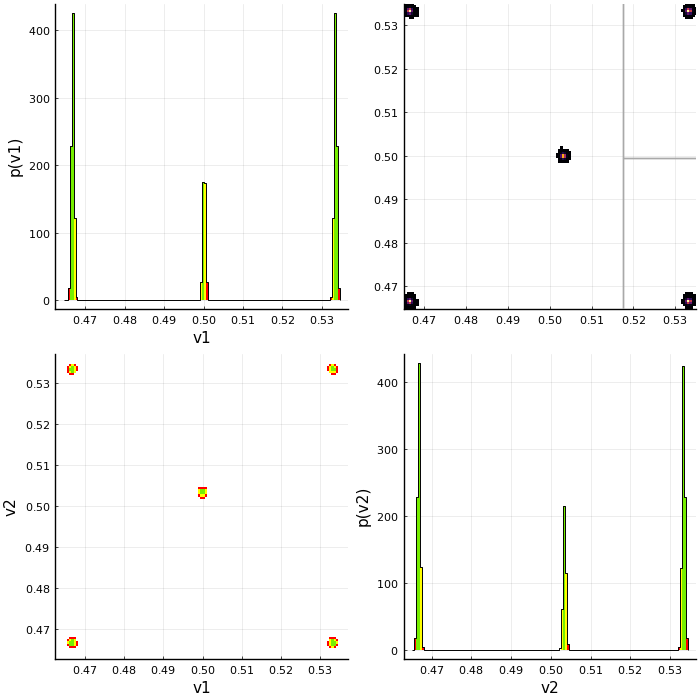

In [11]:
plot(samples_1, size=(700,700), upper=Dict("partition_tree"=>output_sp.part_tree, "mean"=>false, "globalmode"=>false, "localmode"=>false))

In [12]:
smpls = bat_sample(samples_1, OrderedResampling(nsamples=500)).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


In [13]:
evid = sum(output_sp.info.density_integral)

1.1081e-5 ± 3.2e-8

In [14]:
log_volume = BAT.log_volume(BAT.spatialvolume(posterior.parbounds))

true_vals = exp(-log_volume)

1.1111111111111115e-5

In [15]:
resampled_trees

LoadError: UndefVarError: resampled_trees not defined

In [16]:
colors = cgrad(:viridis, length(resampled_trees)+1, rev=true, categorical = true)

p = plot(smpls, size=(700,700), upper=Dict("seriestype"=>:scatter, "partition_tree"=>output_sp.part_tree, "linewidth"=>0.0))

for (ind, vals) in enumerate(reverse(resampled_trees))
    p = plot!(smpls, size=(700,700), upper=Dict("seriestype"=>:scatter, "partition_tree"=>vals, "mean"=>false, "linecolor"=>colors[ind], "linealpha"=>0.7, "globalmode"=>false, "localmode"=>false, "linewidth"=>1))
end

p = plot!(smpls, size=(700,700), upper=Dict("seriestype"=>:scatter, "partition_tree"=>output_sp.part_tree, "linecolor"=>colors[end], "mean"=>false, "globalmode"=>false, "localmode"=>false, "linewidth"=>1))


p

LoadError: UndefVarError: resampled_trees not defined

# 2-D Toy:

In [35]:
ϕ = 0:1:10

x = exp.(0.3 .* ϕ) .* cos.(ϕ)
y = exp.(0.3 .* ϕ) .* sin.(ϕ);

In [36]:
weights_dist = ones(length(x)) .+ rand(Uniform(-0.3, 0.3), length(x))
weights_dist = weights_dist ./ sum(weights_dist)

mixture_model = MixtureModel(MvNormal[MvNormal([x[i],y[i]], [0.04*sqrt(x[i]^2+y[i]^2), 0.04*sqrt(x[i]^2+y[i]^2) ]) for i in 1:length(x)], weights_dist);

prior = NamedTupleDist(a = [Uniform(-200,200), Uniform(-200,200)])

likelihood = let model = mixture_model
    params -> LogDVal(logpdf(model, params.a))
end

posterior = PosteriorDensity(likelihood, prior);

log_volume = BAT.log_volume(BAT.spatialvolume(posterior.parbounds))

11.982929094215963

In [37]:
iid_distributions = NamedTupleDist(a = mixture_model,)
samples_iid = bat_sample(iid_distributions, IIDSampling(nsamples=10^6)).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


In [38]:
samples_mcmc = bat_sample(posterior, MCMCSampling(nsteps=10^4, nchains=4, trafo=PriorToUniform(), strict=false)).result;

# NoDensityTransform() PriorToUniform

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:174
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:69
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_b

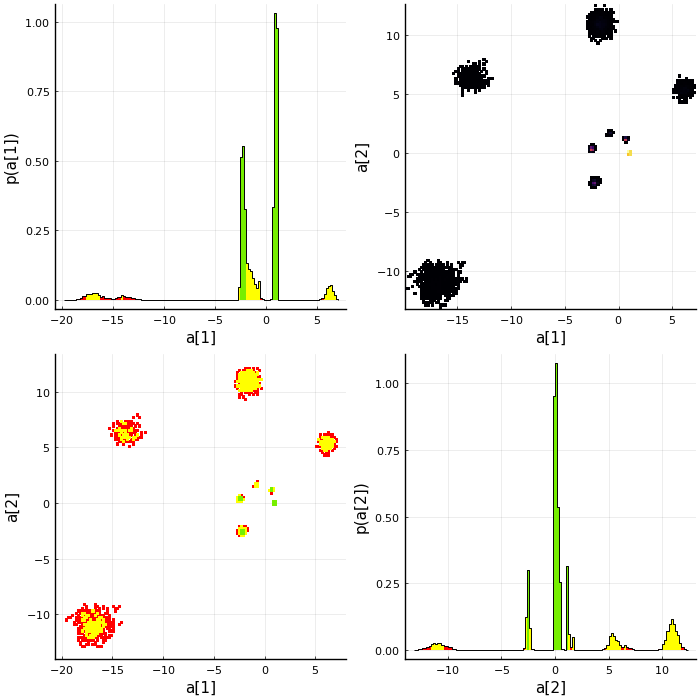

In [39]:
plot(samples_mcmc, size=(700,700), )

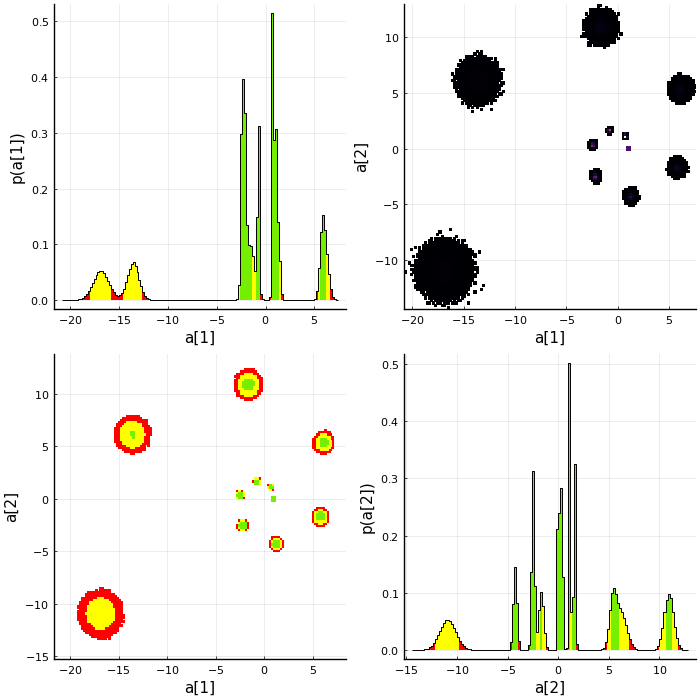

In [40]:
plot(samples_iid, size=(700,700), )

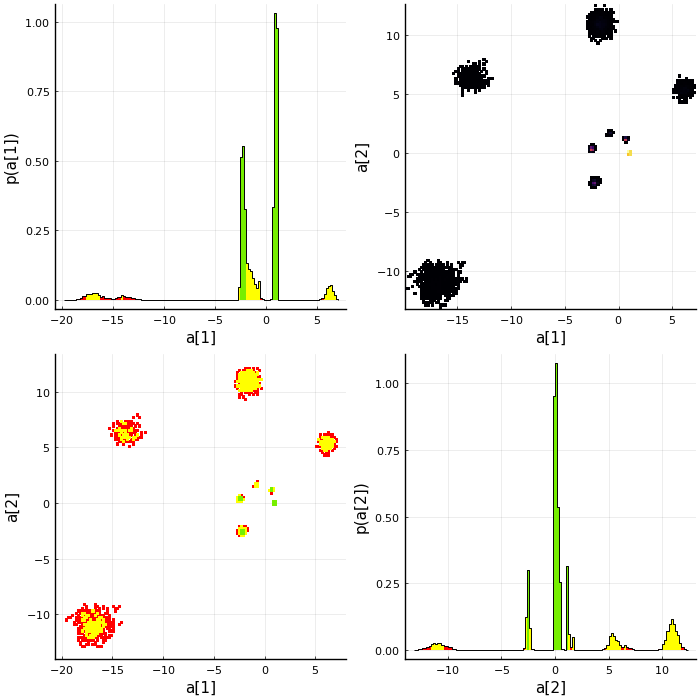

In [41]:
plot(samples_mcmc, size=(700,700), )

In [42]:
prior = NamedTupleDist(a = [Uniform(-150,150), Uniform(-150,150)])

likelihood = let model = mixture_model
    params -> LogDVal(logpdf(model, params.a))
end

posterior = PosteriorDensity(likelihood, prior);

log_volume = BAT.log_volume(BAT.spatialvolume(posterior.parbounds))

11.407564949312402

In [43]:
mcmc = MCMCSampling(mcalg = MetropolisHastings(), nchains=6, nsteps = 10^5, trafo = NoDensityTransform(), strict=false)

mcmc_exp = MCMCSampling(mcalg = MetropolisHastings(), nsteps = 1000, nchains=20, trafo = NoDensityTransform(), strict=false)

algorithm_1 = PartitionedSampling(sampler = mcmc, npartitions=5, exploration_sampler=mcmc_exp, nmax_resampling=10)

output_sp = bat_sample(posterior, algorithm_1);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Generating Exploration Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/partitioned_sampling/partition_sample.jl:43
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm DensityIdentityTransform()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 20 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 20 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:174
┌ Info:

In [44]:
samples_1 = output_sp.result;
resampled_trees = output_sp.resampled_trees;

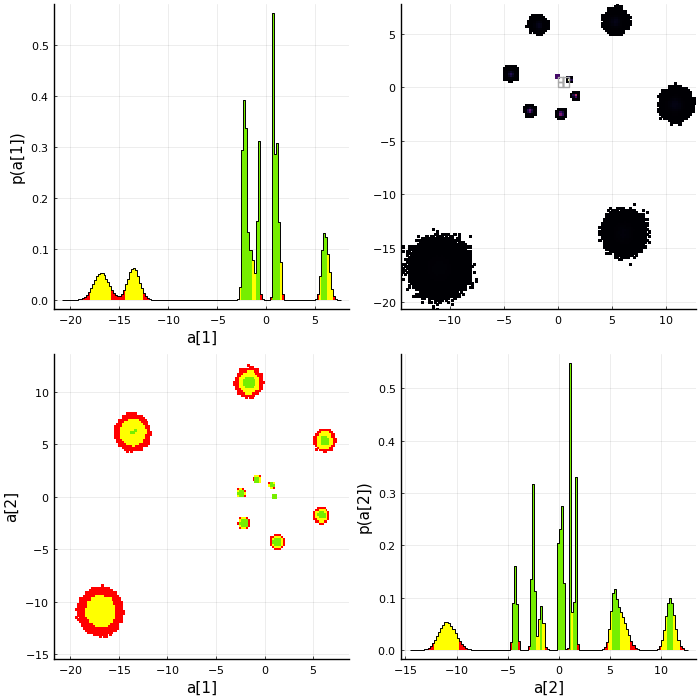

In [45]:
plot(samples_1, size=(700,700), upper=Dict("partition_tree"=>output_sp.part_tree, "mean"=>false, "globalmode"=>false, "localmode"=>false))

In [46]:
smpls = bat_sample(output_sp.result_trafo, OrderedResampling(nsamples=500)).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


In [47]:
resampled_trees

Any[]

In [48]:
colors = cgrad(:viridis, length(resampled_trees)+1, rev=true, categorical = true)

p = plot(smpls, size=(700,700), upper=Dict("seriestype"=>:scatter, "partition_tree"=>output_sp.part_tree, "linewidth"=>0.0))

for (ind, vals) in enumerate(reverse(resampled_trees))
    p = plot!(smpls, size=(700,700), upper=Dict("seriestype"=>:scatter, "partition_tree"=>vals, "mean"=>false, "linecolor"=>colors[ind], "linealpha"=>0.7, "globalmode"=>false, "localmode"=>false, "linewidth"=>1))
end

p = plot!(smpls, size=(700,700), upper=Dict("seriestype"=>:scatter, "partition_tree"=>output_sp.part_tree, "linecolor"=>colors[end], "mean"=>false, "globalmode"=>false, "localmode"=>false, "linewidth"=>1))


p

LoadError: ArgumentError: range(0.0, stop=1.0, length=1): endpoints differ

In [49]:
colors

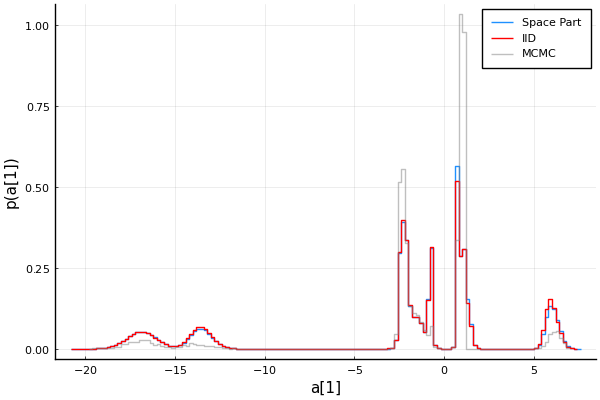

In [52]:
plot(samples_1, 1,  st = :steps, label="Space Part", marginalmode=false)
plot!(samples_iid, 1,  st = :steps, linecolor=:red, label="IID", marginalmode=false, )
plot!(samples_mcmc, 1,  st = :steps, linecolor=:gray, label="MCMC", marginalmode=false, alpha=0.5, )
# plot!(ylim=(0, 0.2))

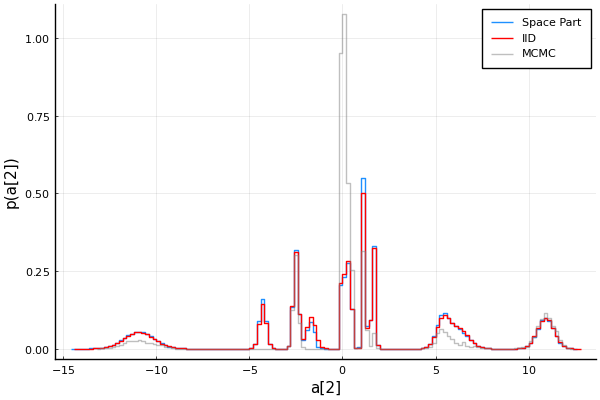

In [53]:
plot(samples_1, 2,  st = :steps, label="Space Part", marginalmode=false)
plot!(samples_iid, 2,  st = :steps, linecolor=:red, label="IID", marginalmode=false, )
plot!(samples_mcmc, 2,  st = :steps, linecolor=:gray, label="MCMC", marginalmode=false, alpha=0.5, )
# plot!(ylim=(0, 0.2))

# 9-D Problem: 

In [ ]:
ϕ = 1:1:8

x = exp.(0.3 .* ϕ) .* cos.(ϕ)
y = exp.(0.3 .* ϕ) .* sin.(ϕ);
z = exp.(0.3 .* ϕ) .* sin.(1.1.* ϕ)
e = exp.(0.3 .* ϕ) .* sin.(1.5 .* ϕ)
f = exp.(0.3 .* ϕ) .* sin.(1.2 .* ϕ)
# k = exp.(0.3 .* ϕ) .* sin.(1.7 .* ϕ)
# m = exp.(0.3 .* ϕ) .* sin.(0.7 .* ϕ)
# a = exp.(0.3 .* ϕ) .* sin.(4.7 .* ϕ)
# u = exp.(0.3 .* ϕ) .* sin.(5.7 .* ϕ)


r = 0.05.*sqrt.(x.^2 .+y.^2)

weights_dist = ones(length(x)) .+ rand(Uniform(-0.2, 0.2), length(x))
weights_dist = weights_dist ./ sum(weights_dist)

weights_dist = 1 ./r.^2 ; weights_dist = weights_dist ./ sum(weights_dist)

# mixture_model = MixtureModel(MvNormal[MvNormal([x[i],y[i],z[i],e[i], f[i], k[i], m[i], a[i], u[i]], [r[i] for _ in 1:9]) for i in 1:length(x)], weights_dist);
# mixture_model = MixtureModel(MvNormal[MvNormal([x[i],y[i],z[i],e[i], f[i]], [r[i] for _ in 1:5]) for i in 1:length(x)], weights_dist);
mixture_model = MixtureModel(MvNormal[MvNormal([x[i],y[i],z[i],e[i]], [r[i] for _ in 1:4]) for i in 1:length(x)], weights_dist);
# mixture_model = MixtureModel(MvNormal[MvNormal([x[i],y[i],z[i]], [r[i] for _ in 1:3]) for i in 1:length(x)], weights_dist);


plot(x, y)

In [ ]:
iid_distributions = NamedTupleDist(a = mixture_model,)
samples_iid = bat_sample(iid_distributions, IIDSampling(nsamples=10^6)).result;

In [ ]:
plot(samples_iid, vsel=1:5, size=(1000,1000))

In [ ]:
prior = NamedTupleDist(a = [Uniform(-20,20) for i in 1:4])

likelihood = let model = mixture_model
    params -> LogDVal(logpdf(model, params.a))
end

posterior = PosteriorDensity(likelihood, prior);

In [ ]:
init_1 = MCMCChainPoolInit(
    init_tries_per_chain = 50 .. 150,
    nsteps_init = 1500
)

burnin_1 = MCMCMultiCycleBurnin(
    max_ncycles = 40,
    nsteps_per_cycle = 20000
)

init_2 = MCMCChainPoolInit(
    init_tries_per_chain = 50 .. 150,
    nsteps_init = 5000
)

burnin_2 = MCMCMultiCycleBurnin(
    max_ncycles = 40,
    nsteps_per_cycle = 100000
)

integrator = AHMIntegration(  
        whitening= CholeskyPartialWhitening(), #CholeskyPartialWhitening(),
        autocorlen= GeyerAutocorLen(),
        volumetype = :HyperRectangle,
        max_startingIDs = 10000,
        max_startingIDs_fraction = 2.5,
        rect_increase = 0.1,
        warning_minstartingids = 16,
        dotrimming = true,
        uncertainty= [:cov]
    )

mcmc = MCMCSampling(mcalg = MetropolisHastings(), init=init_1, burnin=burnin_1,  nchains=6, nsteps = 10^6, trafo = NoDensityTransform(), strict=false)

mcmc_exp = MCMCSampling(mcalg = MetropolisHastings(), nsteps = 1200, nchains=20, trafo = NoDensityTransform(), init=init_2, burnin=burnin_2,  strict=false)

algorithm_1 = PartitionedSampling(sampler = mcmc, npartitions=11, exploration_sampler=mcmc_exp, nmax_resampling=5, integrator=integrator)

output_sp = bat_sample(posterior, algorithm_1);

In [ ]:
samples_1 = output_sp.result;
resampled_trees = output_sp.resampled_trees;

In [ ]:
plot(samples_1, vsel=1:5, size=(1000,1000), upper=Dict("partition_tree"=>output_sp.part_tree, "mean"=>false, "globalmode"=>false, "localmode"=>false))

In [ ]:
length(resampled_trees)

In [ ]:
plot(samples_1, 1,  st = :steps, label="Space Part", marginalmode=false)
plot!(samples_iid, 1,  st = :steps, linecolor=:red, label="IID", marginalmode=false, )

In [ ]:
plot(samples_1, 2,  st = :steps, label="Space Part", marginalmode=false)
plot!(samples_iid, 2,  st = :steps, linecolor=:red, label="IID", marginalmode=false, )

In [ ]:
smpls = bat_sample(samples_1, OrderedResampling(nsamples=400)).result;

In [ ]:
colors = cgrad(:viridis, length(resampled_trees)+1, rev=true, categorical = true)

p = plot(smpls, size=(700,700), upper=Dict("seriestype"=>:scatter, "partition_tree"=>output_sp.part_tree, "linewidth"=>0.0))

for (ind, vals) in enumerate(reverse(resampled_trees))
    p = plot!(smpls, size=(700,700), upper=Dict("seriestype"=>:scatter, "partition_tree"=>vals, "mean"=>false, "linecolor"=>colors[ind], "linealpha"=>0.7, "globalmode"=>false, "localmode"=>false, "linewidth"=>1))
end

p = plot!(smpls, size=(700,700), upper=Dict("seriestype"=>:scatter, "partition_tree"=>output_sp.part_tree, "linecolor"=>colors[end], "mean"=>false, "globalmode"=>false, "localmode"=>false, "linewidth"=>1))


p